Applied NumPy workaround for pandas-ta compatibility.
Config loaded successfully.
Loading processed price data from: ..\data/processed/price_data_processed.parquet
Processed price data loaded successfully.
Shape: (3547406, 5)
                        Open     High      Low    Close  Volume
Timestamp                                                      
2015-01-01 23:01:00  4240.25  4245.50  4240.25  4245.50     207
2015-01-01 23:02:00  4245.25  4245.25  4244.25  4245.25      53
2015-01-01 23:03:00  4244.75  4245.00  4244.00  4244.50      28
2015-01-01 23:04:00  4244.50  4244.50  4242.75  4244.50      66
2015-01-01 23:05:00  4244.75  4245.75  4244.50  4245.50      32

Calculating features...
Calculating base indicators...
Calculating time features...
Calculating daily and ORB context features...
Calculating strategy filter and interaction features...
Lagging features...
Dropping rows with initial NaNs from essential indicators...
Dropped 51 rows (essential indicator lags).
Forward fillin

c:\Users\Rayyan Khan\Desktop\ORBML2\src\feature_engineering.py:306: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  df[context_cols_present] = df.groupby(df.index.date, group_keys=False)[context_cols_present].fillna(method='ffill')
c:\Users\Rayyan Khan\Desktop\ORBML2\src\feature_engineering.py:306: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[context_cols_present] = df.groupby(df.index.date, group_keys=False)[context_cols_present].fillna(method='ffill')


Dropped 298330 rows after ffill/final context check.
Final shape after NaN handling: (3249025, 70)
Feature engineering complete.

Features calculated.

Features DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3249025 entries, 2015-01-02 08:46:00 to 2025-03-25 13:42:00
Data columns (total 70 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   Open                              float64
 1   High                              float64
 2   Low                               float64
 3   Close                             float64
 4   Volume                            int64  
 5   ATR_14                            float64
 6   ATR_50                            float64
 7   RSI_7                             float64
 8   SMA_15                            float64
 9   SMA_20                            float64
 10  Volume_SMA_20                     float64
 11  Volatility_20                     float64
 12  ROC_10        

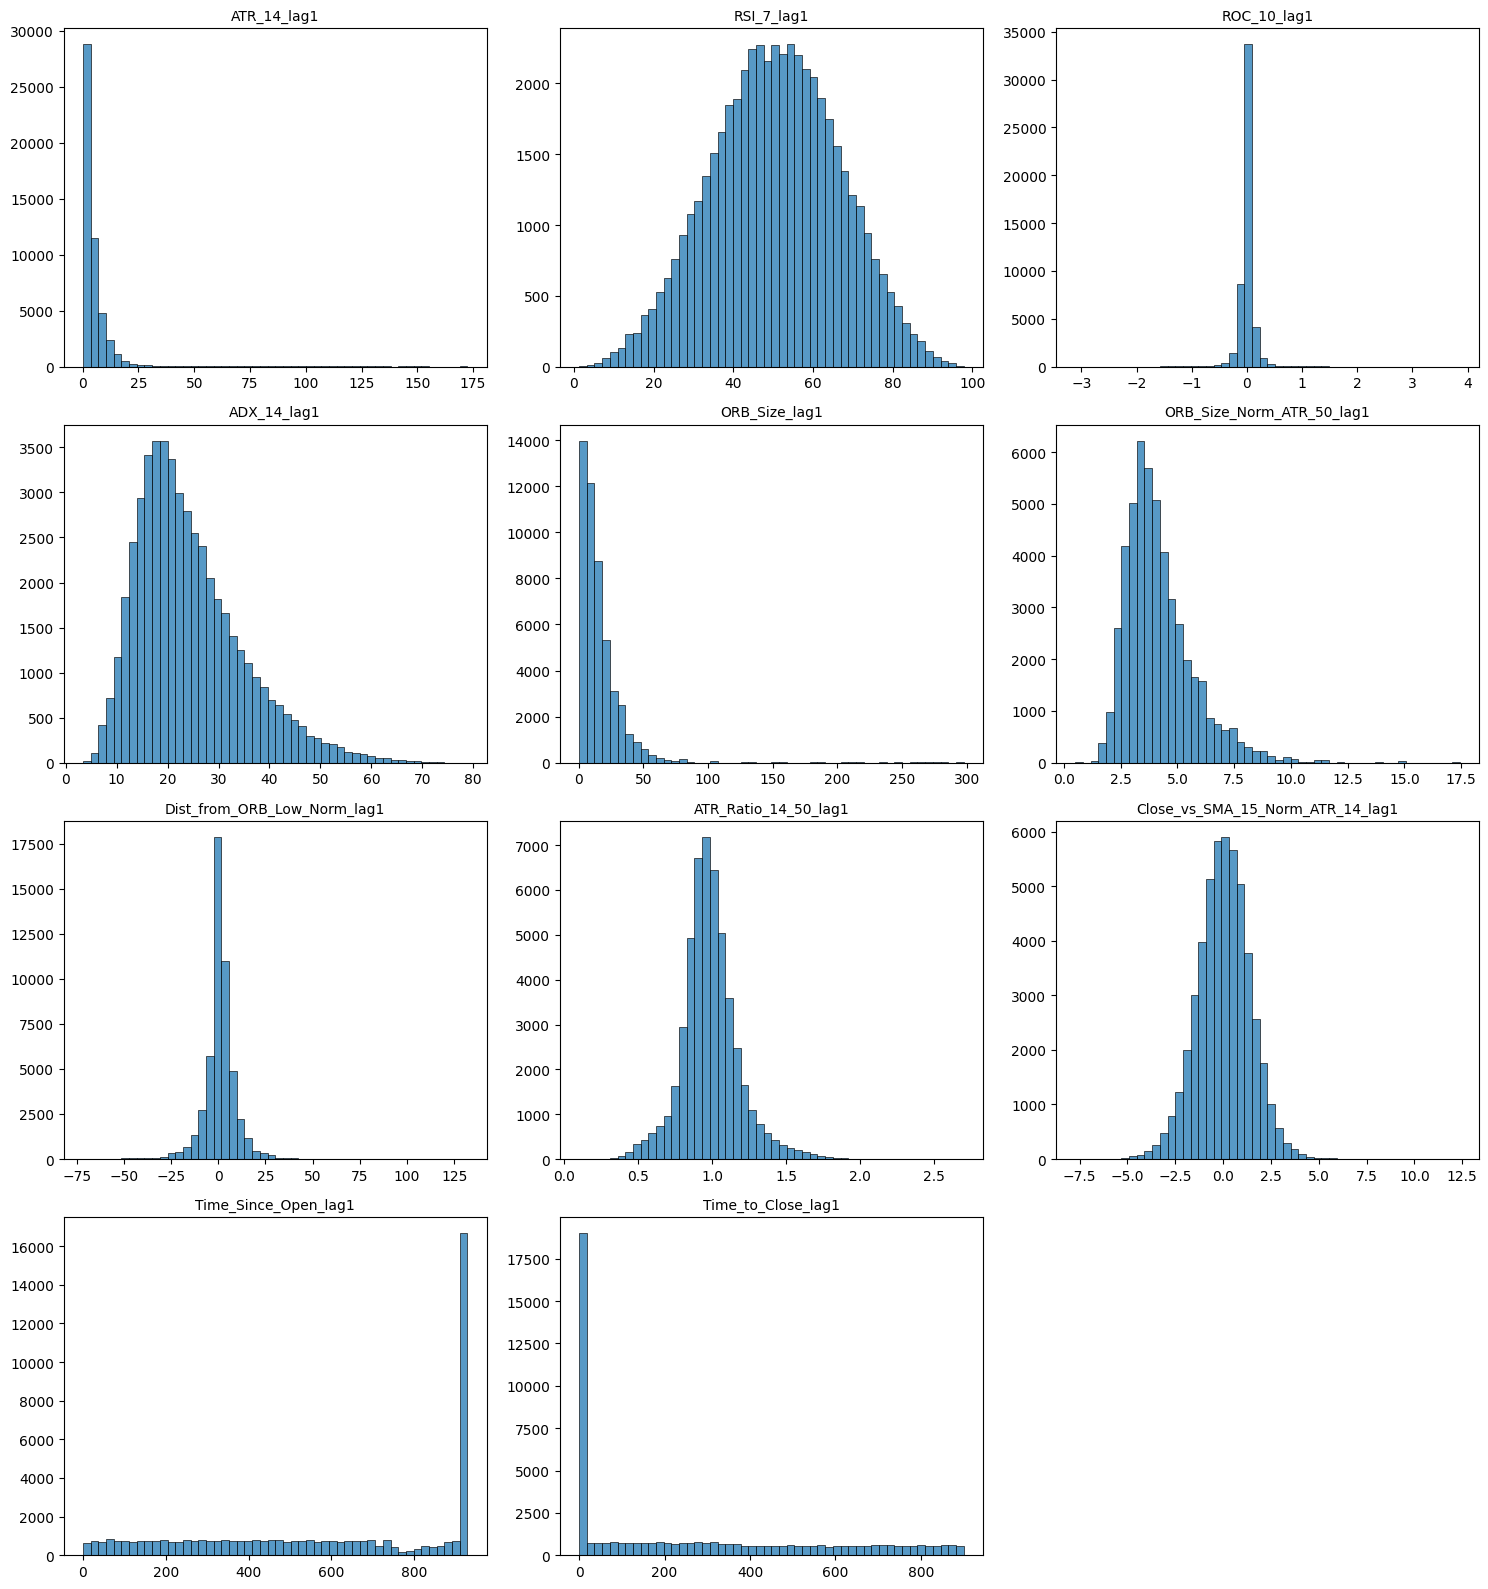


Time_Since_Open            1040646
ORB_High                     34989
ORB_Low                      34989
ORB_Size                     36008
ORB_Size_Norm_ATR_50         48713
Dist_from_ORB_Low_Norm     1107548
Dist_from_ORB_High_Norm    1107548
Interaction_RSI_DistORB    1107548
dtype: int64

Attempting to save data with features to: ..\data/processed/features_and_labels.parquet
Data with features saved successfully. Shape: (3249025, 70)


In [1]:
# %% [markdown]
# # 2. Feature Engineering
#
# **Purpose:** Load the processed price data, calculate technical indicators and other features (including lagged versions), and save the results. Includes ORB context, daily context, momentum, and trend strength.

# %%
import pandas as pd
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Import custom functions
import sys
# Add src directory to path for importing modules
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from feature_engineering import add_features # Import the main feature adding function

# Set display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50) # Keep 50, info() shows all cols

# %% [markdown]
# ## Load Configuration

# %%
CONFIG_PATH = '../config/config.yaml'
try:
    with open(CONFIG_PATH, 'r') as f:
        config = yaml.safe_load(f)
    print("Config loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: Config file not found at {CONFIG_PATH}")
    config = None
except Exception as e:
    print(f"ERROR loading config: {e}")
    config = None

if config is None:
    raise ValueError("Failed to load configuration.")

# Define paths
PROCESSED_DIR = os.path.join('..', config['data_paths']['processed_dir'])
PROCESSED_PRICE_FILE = os.path.join(PROCESSED_DIR, config['processed_files']['price_data'])
# Output file for this notebook (will include features)
FEATURES_FILE = os.path.join(PROCESSED_DIR, config['processed_files']['features_labels'])

# %% [markdown]
# ## Load Processed Price Data

# %%
print(f"Loading processed price data from: {PROCESSED_PRICE_FILE}")
price_df = None # Initialize
try:
    price_df = pd.read_parquet(PROCESSED_PRICE_FILE)
    print("Processed price data loaded successfully.")
    print(f"Shape: {price_df.shape}")
    print(price_df.head())
except FileNotFoundError:
    print(f"ERROR: Processed price data file not found at {PROCESSED_PRICE_FILE}. Run Notebook 01 first.")
except Exception as e:
    print(f"ERROR loading processed price data: {e}")

# %% [markdown]
# ## Calculate Features
# Use the `add_features` function from `src/feature_engineering.py`. This function should calculate indicators (ATR, RSI, SMAs, Volatility, etc.) and crucially, create lagged versions (`_lag1`) for modeling. It now also adds ORB/Daily context, ROC, ADX, MACD, and other derived features.

# %%
features_df = None # Initialize
if price_df is not None:
    print("\nCalculating features...")
    try:
        # Pass the entire dataframe and config, the function handles calculations and lagging
        features_df = add_features(price_df.copy(), config) # Pass the config dictionary
        print("\nFeatures calculated.")

        print("\nFeatures DataFrame Info:")
        features_df.info() # This will show all columns
        print("\nFeatures DataFrame Head (showing sample features):")
        # Display relevant columns to check calculations
        fp = config['feature_params'] # Get feature params periods
        sp = config['strategy_params']
        cols_to_show = ['Close',
                        f"ATR_{fp['atr_period']}_lag1",
                        f"RSI_{fp['rsi_period']}_lag1",
                        f"ROC_{fp['roc_period']}_lag1",
                        f"ADX_{fp['adx_period']}_lag1",
                        f"MACDh_{fp['macd_fast']}_{fp['macd_slow']}_{fp['macd_signal']}_lag1", # MACD Hist
                        'ORB_Size_lag1',
                        f"ORB_Size_Norm_ATR_{fp['atr_long_period']}_lag1",
                        'Dist_from_ORB_Low_Norm_lag1',
                        'IsTrendingUp_lag1',
                        'Time_Since_Open_lag1',
                        'Time_to_Close_lag1']
        cols_to_show_present = [c for c in cols_to_show if c in features_df.columns]
        print(features_df[cols_to_show_present].head())

        print("\nChecking for NaNs after feature calculation:")
        nans = features_df.isnull().sum()
        print(nans[nans > 0]) # Only print columns that still have NaNs

        # Final check if any NaNs remain after internal handling
        if features_df.isnull().any().any():
             print("Warning: NaNs still present after feature engineering function. Consider adding dropna here if needed.")
             # features_df.dropna(inplace=True) # Uncomment to force drop all remaining NaNs

    except Exception as e:
        print(f"ERROR during feature calculation cell: {e}")
        import traceback
        traceback.print_exc()
        features_df = None # Ensure it's None if calculation failed

else:
    print("Skipping feature calculation as data loading failed.")


# %% [markdown]
# ## Explore New Features (Example Plots)
# Visualize distributions of some key new features.

# %%
if features_df is not None:
    print("\nExploring feature distributions (including new ones)...")
    # Define dynamic feature names based on config
    fp = config['feature_params']
    sp = config['strategy_params']
    # Select a mix of original and new features to plot
    features_to_plot = [
        f'ATR_{fp["atr_period"]}_lag1',
        f'RSI_{fp["rsi_period"]}_lag1',
        f'ROC_{fp["roc_period"]}_lag1',
        f'ADX_{fp["adx_period"]}_lag1',
        f'MACDh_{fp["macd_fast"]}_{fp["macd_slow"]}_{fp["macd_signal"]}_lag1', # MACD Hist
        'ORB_Size_lag1',
        f'ORB_Size_Norm_ATR_{fp["atr_long_period"]}_lag1',
        'Dist_from_ORB_Low_Norm_lag1',
        f'ATR_Ratio_{fp["atr_period"]}_{fp["atr_long_period"]}_lag1',
        f'Close_vs_SMA_{sp["fastSMAPeriod"]}_Norm_ATR_{fp["atr_period"]}_lag1',
        'Time_Since_Open_lag1',
        'Time_to_Close_lag1'
    ]

    # Filter list to only include columns that actually exist in the dataframe
    features_to_plot_present = [f for f in features_to_plot if f in features_df.columns]

    if features_to_plot_present:
        num_plots = len(features_to_plot_present)
        num_cols = 3 # Adjust layout as needed
        num_rows = int(np.ceil(num_plots / num_cols))

        print(f"Plotting distributions for {num_plots} features...")
        plt.figure(figsize=(num_cols * 5, num_rows * 4))
        for i, feature in enumerate(features_to_plot_present):
            plt.subplot(num_rows, num_cols, i + 1)
            # Use sample for large data to speed up plotting
            # Also handle potential infinite values before plotting
            data_to_plot = features_df[feature].replace([np.inf, -np.inf], np.nan).dropna()
            if not data_to_plot.empty:
                 plot_sample = data_to_plot.sample(min(50000, len(data_to_plot)))
                 sns.histplot(plot_sample, bins=50, kde=False)
                 plt.title(feature, fontsize=10) # Smaller title
                 plt.xlabel('') # Keep axis labels clean
                 plt.ylabel('')
            else:
                 plt.title(f'{feature}\n(No Valid Data)', fontsize=10)

        plt.tight_layout()
        plt.show()
    else:
        print("No features found to plot.")
else:
    print("Skipping feature exploration.")

# %% [markdown]
# ## Save Data with Features
# Save the dataframe containing prices and all calculated (including lagged) features. This will be the input for regime detection and meta-labeling preparation.

# %%
if features_df is not None:
    # Final NaN check before saving
    final_nans = features_df.isnull().sum()
    if final_nans.sum() > 0:
        print("\nWarning: NaNs detected before saving! Consider handling them.")
        print(final_nans[final_nans > 0])
        # Force drop remaining NaNs if deemed necessary for models
        # print("Dropping remaining NaN rows before saving...")
        # features_df.dropna(inplace=True)

    if not features_df.empty:
        try:
            # Using the FEATURES_FILE path defined earlier
            print(f"\nAttempting to save data with features to: {FEATURES_FILE}")
            features_df.to_parquet(FEATURES_FILE)
            print(f"Data with features saved successfully. Shape: {features_df.shape}")
        except Exception as e:
            print(f"ERROR saving data with features: {e}")
    else:
        print("\nSkipping saving features data as dataframe is empty after processing.")

else:
    print("\nSkipping saving features data as dataframe is None.")

# %% [markdown]
# ---
# End of Notebook 02
# ---